In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [7]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7ws07/'


file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [4]:
#get fields psi
pfile0 = dir0 + file0
pfile1 = dir1 + file0

#wind forcing
forcing_z = dir0 + file1

#buyoancy forcing
forcing_b = dir0 + file1

f1 = netcdf.netcdf_file(dir0 + file0,'r')
f2 = netcdf.netcdf_file(dir0 + file1,'r')


In [5]:
N2,f0 = qg.reshape3d(dh,N2,f0)

si_t = f1.variables['time'][:].copy().size

p = qg.read_qgcm(pfile0, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nl,N,naux = p.shape

test = si_t

average = True

In [11]:
%%time

# means

p_me_ws07 = np.zeros((nl,N,N))
s_me_ws07 = np.zeros((nl,N,N))

n_me=1

for it in range(0,test):
    
    p = qg.read_qgcm(pfile0, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    s = qg.p2stretch(p,dh, N2,f0)
  
    # mean for saving
    p_me_ws07 += (p - p_me_ws07)/n_me
    s_me_ws07 += (s - s_me_ws07)/n_me
    
    n_me += 1
    

CPU times: user 34.9 s, sys: 2.39 s, total: 37.3 s
Wall time: 4min 30s


In [13]:
%%time

# rectification term for MPE

jac_pe_ws07 = np.zeros((nl,N,N))

n_me=1

for it in range(0,test):
    
    p = qg.read_qgcm(pfile0, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    s = qg.p2stretch(p,dh, N2,f0)
    
    p_p = p - p_me_ws07
    s_p = s - s_me_ws07
    
    jps = qg.jacobian(p_p,s_p, Delta)
    
    jac_pe_ws07 += (jps - jac_pe_ws07)/n_me
    
    n_me += 1
    


CPU times: user 1min 1s, sys: 5.69 s, total: 1min 6s
Wall time: 1min 8s


In [14]:
flot_pert_rel_et = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_perturbation_rel.npz')

jac_pe_rel = flot_pert_rel_et['jac_pe']


flot_me_et_rel = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_flot_moyen_rel.npz')

p_me_rel= flot_me_et_rel['p_me']


In [18]:
def forward(x):
    return 1/x

def inverse(x):
    return 1/x


<ipython-input-18-711fb66c38b2>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1/x


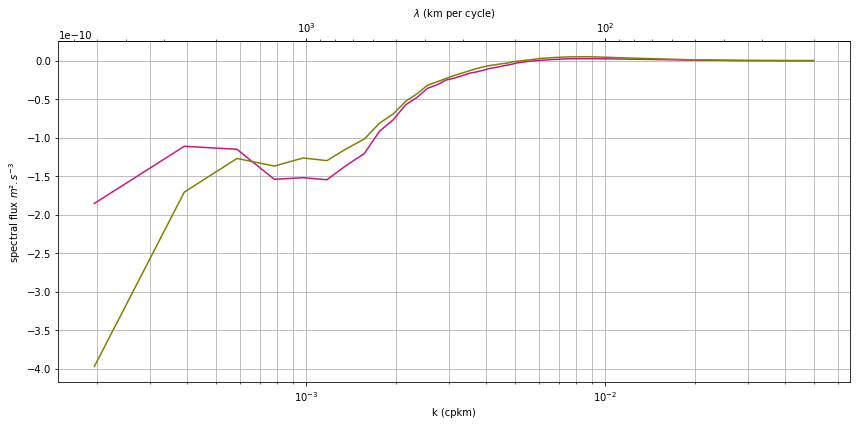

In [19]:
#mean PE to turbulent PE
k_pe_ws07,fl_pe_ws07 = qg.get_spec_flux(psi1=p_me_ws07 , psi2 = jac_pe_ws07 , Delta = Delta)

fl_pe_ws07 = integral_z(fl_pe_ws07, dh=dh, Delta=Delta, Ht = Ht)

k_pe_rel,fl_pe_rel = qg.get_spec_flux(psi1=p_me_rel , psi2 = jac_pe_rel , Delta = Delta)

fl_pe_rel = integral_z(fl_pe_rel, dh=dh, Delta=Delta, Ht = Ht)



fig, ax2 = plt.subplots(1, 1, figsize = (12,6),tight_layout=True)


ax2.plot(k_pe_ws07*1e3, fl_pe_ws07, color = 'mediumvioletred')
ax2.plot(k_pe_rel*1e3, fl_pe_rel, color = 'olive')
#ax2.set_title('bottom drag')
ax2.set_xlabel('k (cpkm)')
ax2.set_ylabel(r'spectral flux $m².s^{-3}$')#($m².s^{-2}.(rad.km^{-1})^{-1}$)')
ax2.set_xscale('log')
#ax1.xaxis.set_major_locator(plt.MultipleLocator(0.001))
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.00025))
secax2 = ax2.secondary_xaxis('top', functions = (forward, inverse))
secax2.set_xlabel(r'$\lambda$ (km per cycle)')
ax2.grid(True, which = 'both')